In [1]:
#this is actually cycle gan
#problem generating dataset

C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\labadmin\appdata\local\temp\pip-req-build-2hja0ref
  Resolved https://github.com/tensorflow/examples.git to commit 5bc9f1ed519146242db5e71f00d9d39d52a308c8
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\labadmin\AppData\Local\Temp\pip-req-build-2hja0ref'


In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [39]:
#create a list of image file paths
DATA_DIR = r"\\shelter\Kyu\unstain2stain\unstain2stain_tile\train"
train_he = sorted(glob.glob(os.path.join(*[DATA_DIR, 'HE\OTS_14684_2_he\*.png'])))
train_unstained = sorted(glob.glob(os.path.join(*[DATA_DIR,'Unstained\OTS_14684_2\*.png'])))
val_he = sorted(glob.glob(os.path.join(*[DATA_DIR, 'HE\OTS_14684_3_he\*.png'])))
val_unstained = sorted(glob.glob(os.path.join(*[DATA_DIR, 'Unstained\OTS_14684_3\*.png'])))

In [41]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

In [42]:
#image pre-process
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [43]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [44]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [45]:
#copied from kyu
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    # image = cv2.imread(image_path.decode('UTF-8'))
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMG_WIDTH, IMG_WIDTH])
        # image[image==13]=0
        image = tf.where(tf.equal(image, 13), tf.zeros_like(image), image)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_WIDTH, IMG_WIDTH])
        # image = image / 127.5 - 1 #[-1 1]
        image = image/255 #[0 1]
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x,y: tf.numpy_function(load_data, [x,y], Tout=tf.uint8))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [46]:
train_dataset = data_generator(train_unstained, train_he)
val_dataset = data_generator(val_unstained, val_he)

In [47]:
train_dataset

<BatchDataset shapes: ((1, 1024, 1024, 3), (1, 1024, 1024, 1)), types: (tf.float32, tf.float32)>

In [54]:
train_horses = train_dataset.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

ValueError: in user code:

    C:\Users\labadmin\AppData\Local\Temp\ipykernel_29336\1722813493.py:2 preprocess_image_train  *
        image = random_jitter(image)
    C:\Users\labadmin\AppData\Local\Temp\ipykernel_29336\2093225660.py:20 random_jitter  *
        image = random_crop(image)
    C:\Users\labadmin\AppData\Local\Temp\ipykernel_29336\2093225660.py:3 random_crop  *
        cropped_image = tf.image.random_crop(
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\ops\random_ops.py:402 random_crop
        math_ops.reduce_all(shape >= size),
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\ops\math_ops.py:1817 wrapper
        return fn(x, y, *args, **kwargs)
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:4048 greater_equal
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\labadmin\.conda\envs\wsi_analysis39\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 4 and 3 for '{{node random_crop/GreaterEqual}} = GreaterEqual[T=DT_INT32](random_crop/Shape, random_crop/size)' with input shapes: [4], [3].


In [55]:
sample_horse = next(iter(train_dataset))

TypeError: Invalid shape (1, 1024, 1024, 3) for image data

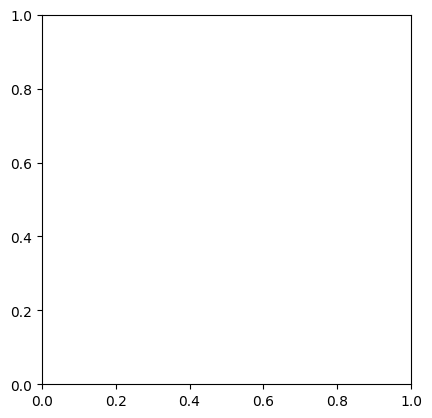

In [53]:
plt.imshow(sample_horse[0])